<a href="https://colab.research.google.com/github/aka2910/hello-git/blob/akshat/Copy_of_Covid_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# !!kaggle.json is required in the /content folder!!
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database 
!unzip /content/*.zip

In [ ]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

path = '/content/'

In [ ]:
#3616 COVID-19 positive, 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection) and 1345 Viral Pneumonia images
#Datasets split as: 875 COVID-19 positive, 2125 Normal (total 3000) per set
#4 sets in total

In [ ]:
#@title Functions
#creates datasets in the Datasets folder

def create_dataset(n):
    arraycov = np.array([cv.imread(file, 0) for file in glob.glob('/content/COVID-19_Radiography_Dataset/COVID/*.png')])[875*(n-1):875*n]/255.0
    arraynorm = np.array([cv.imread(file, 0) for file in glob.glob('/content/COVID-19_Radiography_Dataset/Normal/*.png')])[1125*(n-1):1125*n]/255.0
    print("Step 1: Completed")

    ncov = len(arraycov)
    nnorm = len(arraynorm)

    data_x = np.vstack((arraycov, arraynorm))
    data_y = np.zeros((ncov+nnorm,1))

    for i in range(ncov):
        data_y[i] = 1       
    print("Step 2: Completed")

    np.save(path + 'Datasets/data_set' + str(n), data_x)
    np.save(path + 'Datasets/feature_set' + str(n), data_y)

    print("Process Complete")

#returns (train data), (test data), m train, m test

def train_test_data(dataset_num, blur_index):
    data_x = np.load(path + 'Datasets/data_set' + str(dataset_num) + '.npy')
    data_y = np.load(path + 'Datasets/feature_set' + str(dataset_num) + '.npy')

    data_x = cv.GaussianBlur(data_x, (3,3), blur_index)

    sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 69)
    for train_index, test_index in sss.split(data_x, data_y):
        train_x, train_y = data_x[train_index], data_y[train_index]
        test_x, test_y = data_x[test_index], data_y[test_index]
    
    m_train = len(train_x)
    m_test = len(test_x)

    train_x = train_x.reshape(m_train,299,299,1)
    test_x = test_x.reshape(m_test,299,299,1)

    print("X data (Training set): ", train_x.shape)
    print("Y data (Training set): ", train_y.shape)
    print("X data (Test set): ", test_x.shape)
    print("Y data (Test set): ", test_y.shape)

    return train_x, train_y, test_x, test_y, m_train, m_test   

##Importing processed datasets

In [ ]:
#@title Importing processed datasets 1 and 2
train_x, train_y, test_x, test_y, m_train, m_test = train_test_data(2, 0)
train_x2, train_y2, test_x2, test_y2, m_train2, m_test2 = train_test_data(3, 0)

X data (Training set):  (2100, 299, 299, 1)
Y data (Training set):  (2100, 1)
X data (Test set):  (900, 299, 299, 1)
Y data (Test set):  (900, 1)
X data (Training set):  (2100, 299, 299, 1)
Y data (Training set):  (2100, 1)
X data (Test set):  (900, 299, 299, 1)
Y data (Test set):  (900, 1)


##Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.optimizers import SGD, Adam
from tqdm.keras import TqdmCallback
from keras import backend as k 
from keras.callbacks import EarlyStopping
import sklearn.metrics

In [ ]:
model = Sequential([
                    Conv2D(96, (7,7), strides = (4,4), activation = 'relu', input_shape = (299,299,1)),
                    MaxPool2D((3,3), strides = (2,2)),
                    Dropout(0.2),
                    Conv2D(128, (5,5), strides = (1,1), activation = 'relu', padding = 'same'),
                    BatchNormalization(),
                    Conv2D(128, (5,5), strides = (1,1), activation = 'relu', padding = 'same'),
                    #BatchNormalization(),
                    #Conv2D(128, (5,5), strides = (1,1), activation = 'relu', padding = 'same'),
                    MaxPool2D((3,3), strides = (2,2)),
                    Dropout(0.5),
                    Flatten(),
                    Dense(128, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(2, activation = 'softmax')
])

In [ ]:
def append_history(m1, m2):
    m1.history['accuracy'] = np.append(m1.history['accuracy'], m2.history['accuracy'])
    m1.history['val_accuracy'] = np.append(m1.history['val_accuracy'], m2.history['val_accuracy'])
    m1.history['loss'] = np.append(m1.history['loss'], m2.history['loss'])
    m1.history['val_loss'] = np.append(m1.history['val_loss'], m2.history['val_loss'])

    return m1    

In [ ]:
#k.clear_session()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 74, 74, 96)        4800      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 96)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 128)       307328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 128)       512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 36, 128)       409728    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)      

In [ ]:
optimizer = SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(optimizer = optimizer, loss = SparseCategoricalCrossentropy(), metrics = ['accuracy'])
es_callback = EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
history = model.fit(train_x, train_y, batch_size = 32, 
                    validation_data = (test_x,test_y), validation_batch_size = 16,
                    epochs = 10, verbose = 0, callbacks = [TqdmCallback(verbose=0), es_callback])

k.set_value(model.optimizer.learning_rate, 0.0001)

history1 = model.fit(train_x, train_y, batch_size = 32, 
                     validation_data = (test_x,test_y), validation_batch_size = 16,
                     epochs = 200, verbose = 0, callbacks = [TqdmCallback(verbose=0), es_callback])


NameError: ignored

In [ ]:
es_callback = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [ ]:
history2 = model.fit(train_x, train_y, batch_size = 32, 
                     validation_data = (test_x,test_y), validation_batch_size = 16,
                     epochs = 200, verbose = 0, callbacks = [TqdmCallback(verbose=0)])

In [ ]:
model.evaluate(test_x, test_y)

29/29 [==============================] - 1s 17ms/step - loss: 0.0297 - accuracy: 0.9922


[0.029744667932391167, 0.992222249507904]

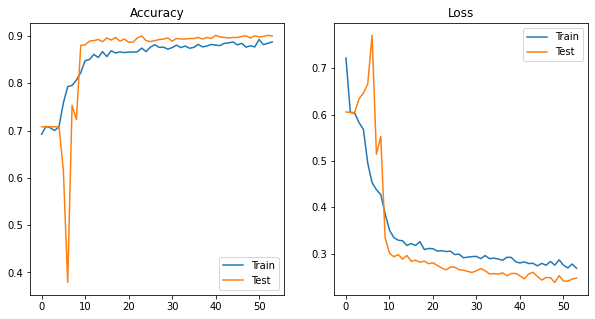

In [ ]:
#history = append_history(history, history1)
history = append_history(history, history2)

#Plots
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title("Accuracy")
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title("Loss")
plt.legend()

plt.show()

In [ ]:
model.save('/content/drive/Shareddrives/Colab Stuff/Covid19/Models/set2_v7_backup.h5')

##Testing on different sets

Summary: Models are trained on the dataset2, using (train_x, train_y) with validation data (test_x, test_y). The following section evaluates the selected model on the data (test_x, test_y) and dataset3

In [ ]:
from keras.models import load_model

In [ ]:
model2 = load_model(path + 'Models/set2_v7.h5')

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 74, 74, 96)        4800      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 96)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 36, 128)       307328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 36, 128)       512       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 128)       409728    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)      

In [ ]:
results = np.array((model2.evaluate(test_x, test_y),  
                   model2.evaluate(test_x2, test_y2), 
                   model2.evaluate(test_x3, test_y3)))
print(results)

29/29 [==============================] - 0s 14ms/step - loss: 0.1265 - accuracy: 0.9633
[[0.02974467 0.99222225]
 [0.03114596 0.98777777]
 [0.12649141 0.96333331]]


In [ ]:
np.average(results, axis=0)

array([0.06246068, 0.98111111])